In [6]:
import dash 
from dash import Dash,dcc,html,callback,Input,Output
import pandas as pd 
import plotly.express as px
import plotly.graph_objects as go

In [24]:
data= pd.read_csv("accidents-velos_clean.csv",low_memory=False)
regions_name= pd.read_csv("departements-region.csv")
data= pd.merge(data, regions_name[['num_dep','region_name']], left_on='dep', right_on='num_dep',how='right')

# contenu de l'appli
ici on stocke tout les graphiques que l'on souhaite afficher dans notre appli

### 1)

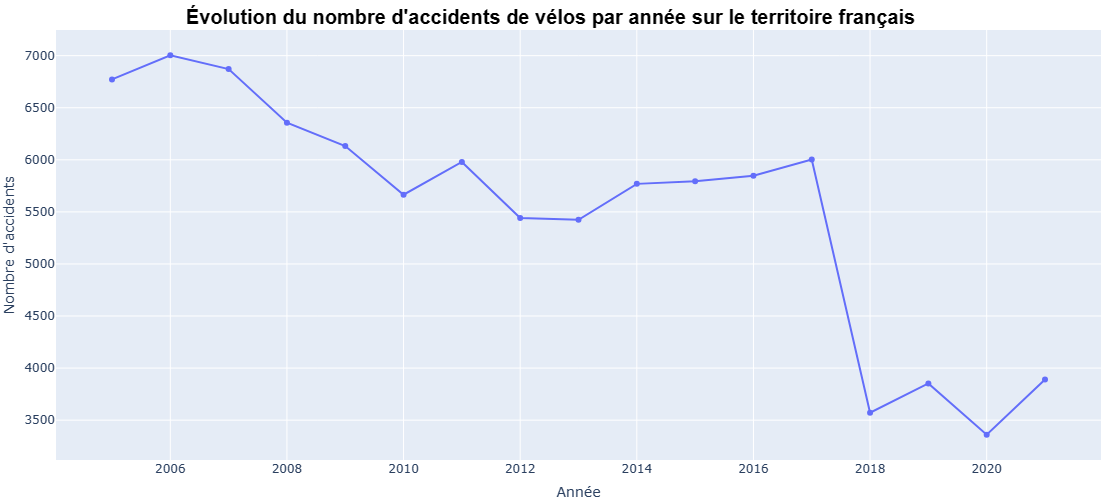

In [35]:
# on calcul les occurences des accidents par année
accidents_par_annee = data.groupby('an').size().reset_index(name='Nombre_d_accidents')
# Créer le lineplot pour la courbe évolutive
fig = px.line(accidents_par_annee, x="an", y="Nombre_d_accidents",
              markers=True,
             custom_data= ['an','Nombre_d_accidents'])
# taille de la figure (largeur, hauteur)
fig.update_layout(width=800, height=500)
#  ajout titre et axes
fig.update_layout(
                  xaxis_title="Année",
                  yaxis_title="Nombre d'accidents")
fig.update_layout(margin = {"r":0,"t":30,"l":0,"b":0},
                 title={
        'text': "<b>Évolution du nombre d\'accidents de vélos par année sur le territoire français</b>",
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20,'family': 'Arial, sans-serif', 'color': 'black'} 
    })

# Personnalisation du popup
fig.update_traces(hovertemplate="<br>".join(["Année : %{customdata[0]}",
                                             "Nombre d'accidents : %{customdata[1]}"
                                             ]),selector= 0)

# Afficher le graphique interactif
fig.show()

## OU

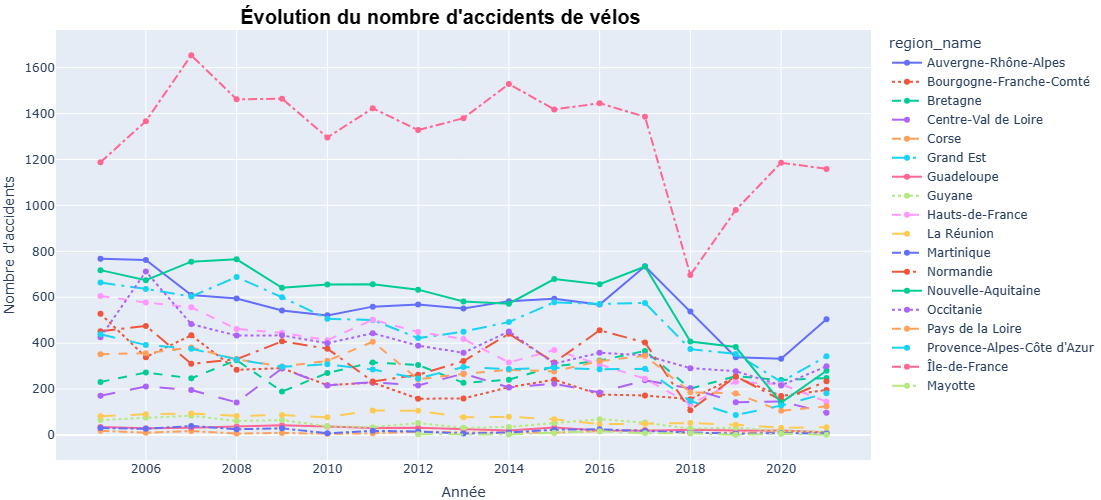

In [32]:

# On calcule les occurrences des accidents par année et par région
accidents_par_annee_region = data.groupby(['an', 'region_name']).size().reset_index(name='Nombre_d_accidents')
# Créer le lineplot pour la courbe évolutive par région
fig = px.line(accidents_par_annee_region, x="an", y="Nombre_d_accidents",
              color="region_name",
              markers=True,
              line_dash="region_name",
              custom_data=['an', 'region_name', 'Nombre_d_accidents'])

# Taille de la figure (largeur, hauteur)
fig.update_layout(width=800, height=500)

# Ajout titre et axes
fig.update_layout(
    xaxis_title="Année",
    yaxis_title="Nombre d'accidents"
)

fig.update_layout(margin={"r": 0, "t": 30, "l": 0, "b": 0},
                  title={
                      'text': "<b>Évolution du nombre d'accidents de vélos</b>",
                      'y': 0.98,
                      'x': 0.4,
                      'xanchor': 'center',
                      'yanchor': 'top',
                      'font': {'size': 20, 'family': 'Arial, sans-serif', 'color': 'black'}
                  })

# Personnalisation du popup
fig.update_traces(hovertemplate="<br>".join(["Année : %{customdata[0]}",
                                             "Région : %{customdata[1]}",
                                             "Nombre d'accidents : %{customdata[2]}"
                                             ]))

# Afficher le graphique interactif
fig.show()

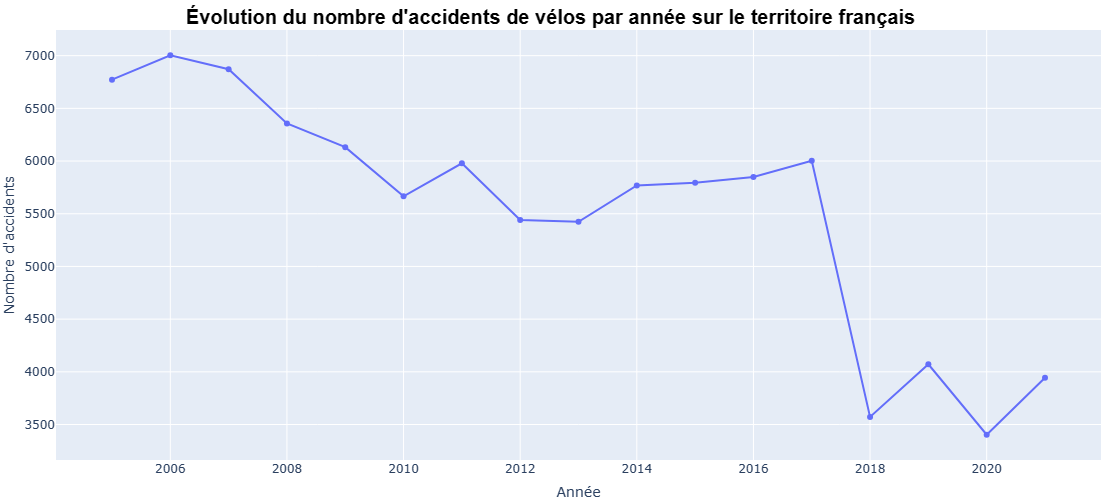

In [9]:
# on calcul les occurences des accidents par année
accidents_par_annee = data.groupby('an').size().reset_index(name='Nombre_d_accidents')
# Créer le lineplot pour la courbe évolutive
fig = px.line(accidents_par_annee, x="an", y="Nombre_d_accidents",
              markers=True,
             custom_data= ['an','Nombre_d_accidents'])
# taille de la figure (largeur, hauteur)
fig.update_layout(width=800, height=500)
#  ajout titre et axes
fig.update_layout(
                  xaxis_title="Année",
                  yaxis_title="Nombre d'accidents")
fig.update_layout(margin = {"r":0,"t":30,"l":0,"b":0},
                 title={
        'text': "<b>Évolution du nombre d\'accidents de vélos en Auvergne rhône-alpes</b>",
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20,'family': 'Arial, sans-serif', 'color': 'black'} 
    })

# Personnalisation du popup
fig.update_traces(hovertemplate="<br>".join(["Année : %{customdata[0]}",
                                             "Nombre d'accidents : %{customdata[1]}"
                                             ]),selector= 0)

# Afficher le graphique interactif
fig.show()

### 2)

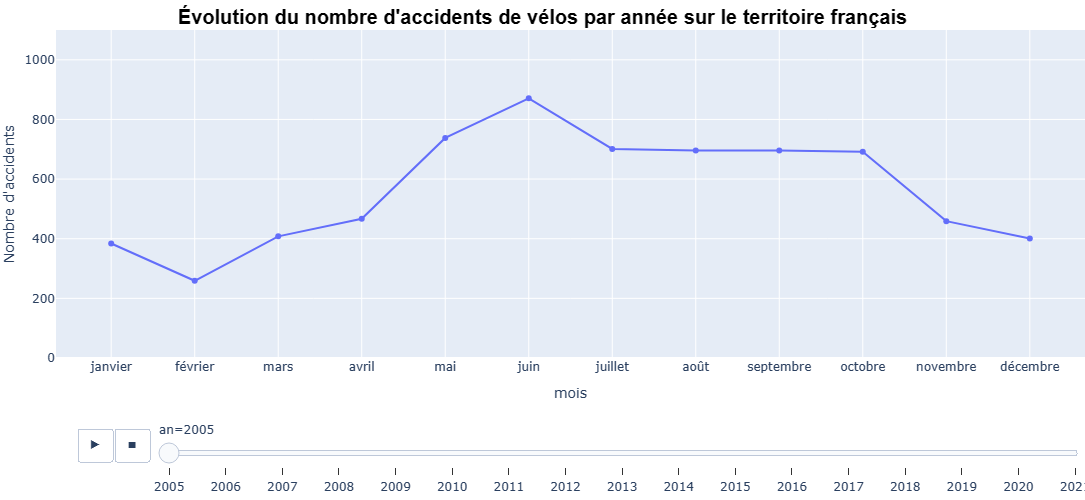

In [33]:
fig2 = px.line(accidents_par_annee_mois, x="mois", y="Nombre_d_accidents", 
              markers=True,animation_frame="an"
             ,custom_data=['an','mois','Nombre_d_accidents'])
# taille de la figure (largeur, hauteur)
fig2.update_layout(width=800, height=500)
#  ajout titre et axes
fig2.update_layout(title="Évolution du nombre d'accidents de vélos par année",
                  xaxis_title="mois",
                  yaxis_title="Nombre d'accidents"
                 )
# ralentir la vitese d'animation
fig2.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1500

# changer l'echelle des ordonnées
fig2.update_yaxes(range=[0, 1100])

# Titre
fig2.update_layout(margin = {"r":0,"t":30,"l":0,"b":0},
                 title={
        'text': "<b>Évolution du nombre d\'accidents de vélos par année sur le territoire français</b>",
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20,'family': 'Arial, sans-serif', 'color': 'black'} 
    })

# Personnalisation du popup
fig2.update_traces(hovertemplate="<br>".join(["Année : %{customdata[0]}",
                                             "Mois : %{customdata[1]}",
                                             "Nombre d'accidents : %{customdata[2]}"
                                             ]),selector= 0)

fig2.show()

### 3)

C:\Users\Alex\AppData\Local\Temp\ipykernel_15908\849947274.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



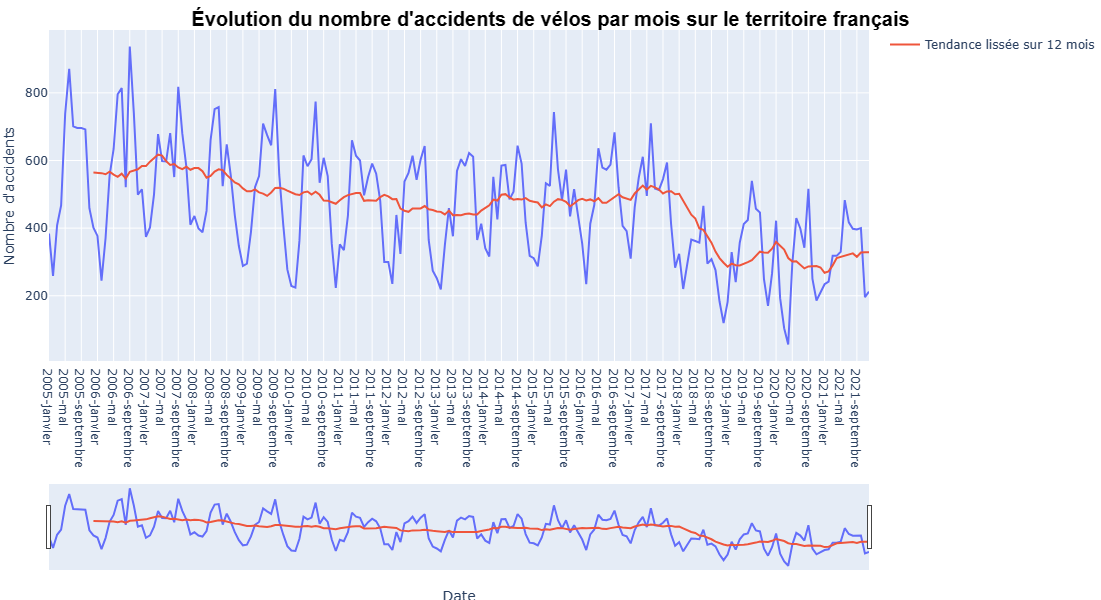

In [12]:
# on prdonne la variable mois pour avoir une année dans l'ordre
mois_ordre = ['janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août', 'septembre', 'octobre', 'novembre', 'décembre']
# Conversion de la variable 'mois' en facteur ordonnné
data['mois'] = pd.Categorical(data['mois'], categories=mois_ordre, ordered=True)

# on récupère les accidents par année et par mois
accidents_par_annee_mois= data.groupby(['an','mois']).size().reset_index(name='Nombre_d_accidents')
# Création d'une variable date en fusionnant les années et les mois
accidents_par_annee_mois['date'] = accidents_par_annee_mois['an'].astype(str) + '-' + accidents_par_annee_mois['mois'].astype(str)

# Création du graphique
fig3 = px.line(accidents_par_annee_mois, x='date', y='Nombre_d_accidents',
              labels={'date': 'Date', 'Nombre_d_accidents': 'Nombre d\'accidents'},
              height=600,
             custom_data = ['an','mois','Nombre_d_accidents'])

# Ajout de la courbe lissé pour observer une tendance
smoothed_data = accidents_par_annee_mois['Nombre_d_accidents'].rolling(window=12).mean() # 12 moyenne mobile pour enlever les saisonnalités annuelles
fig3.add_trace(go.Scatter(x=accidents_par_annee_mois['date'], y=smoothed_data,
                         mode='lines', name='Tendance lissée sur 12 mois'))
# Titre
fig3.update_layout(margin = {"r":0,"t":30,"l":0,"b":0},
                 title={
        'text': "<b>Évolution du nombre d\'accidents de vélos par mois sur le territoire français</b>",
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20,'family': 'Arial, sans-serif', 'color': 'black'} 
    })

#  slider pour zoomer sur une période donnée
fig3.update_xaxes(rangeslider_visible=True)

# Personnalisation du popup
fig3.update_traces(hovertemplate="<br>".join(["Année : %{customdata[0]}",
                                             "Mois : %{customdata[1]}",
                                             "Nombre d'accidents : %{customdata[2]}"
                                             ]),selector= 0)

# Afficher la figure
fig3.show()

In [50]:
# Définissez les intervalles et les labels
bins = [0, 18, 30, 50, float('inf')]
labels = ['Moins de 18 ans', 'Entre 18 et 30 ans', 'Entre 30 et 50 ans', 'Plus de 50 ans']

data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

data.groupby("age_group").size()


C:\Users\Alex\AppData\Local\Temp\ipykernel_15908\3331614574.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



age_group
Moins de 18 ans       17678
Entre 18 et 30 ans    19127
Entre 30 et 50 ans    25210
Plus de 50 ans        31658
dtype: int64

In [173]:
def pie_age_grav(modalite,annee):
    if annee=="all":
        age_mort = data[data["grav"]==modalite].groupby(["age_group"]).size().reset_index(name= "nb_accidents")
    else:
        age_mort = data[(data["grav"]==modalite) & (data["an"]==annee)].groupby(["age_group"]).size().reset_index(name= "nb_accidents")
    
    labels = age_mort["age_group"]
    values = age_mort["nb_accidents"]
    
    if modalite == "Indemne":
        color=['#c2f0c2', '#7ccf7c', '#4cae4c', '#238b23']
    elif modalite == "Blessé léger":
        color = ['#add8e6', '#87ceeb', '#6495ed', '#4169e1']
    elif modalite == "Blessé hospitalisé":
        color = ['#ffdab9', '#ffcc80', '#ffa54f', '#ff8c00']
    else:
        color = ['#ffb6c1', '#ff9999', '#ff6666', '#ff3333']
        
    fig4 = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0, 0, 0.2], marker_colors=color)])
    fig4.update_traces(name = modalite,hovertemplate="Age de l'usager: %{label}<br>Nombre d'accidents: %{value}<br>Pourcentage: %{percent}")
    fig4.update_layout(title= "Proportion d'accidents cycliste en fonction de l'âge de l'usager",
                  title_x=0.5,  # Centré horizontalement
                  title_y=0.98,  # Au-dessus du graphique
                  title_font=dict(size=20),
                 legend=dict(title="Age de l'usager:")
    )
    return fig4

In [201]:
mod = data["an"].unique()
mod.sort()
mod = ["all"]+ mod.tolist()
mod

['all',
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021]

# switch changement thème

In [58]:
from dash import Dash, html, dcc, Input, Output, Patch, clientside_callback, callback
import plotly.express as px
import plotly.io as pio
import dash_bootstrap_components as dbc
from dash_bootstrap_templates import load_figure_template

# adds  templates to plotly.io
load_figure_template(["minty", "minty_dark"])


df = px.data.gapminder()

app = Dash(__name__, external_stylesheets=[dbc.themes.MINTY, dbc.icons.FONT_AWESOME])

color_mode_switch =  html.Span(
    [
        dbc.Label(className="fa fa-moon", html_for="color-mode-switch"),
        dbc.Switch( id="color-mode-switch", value=False, className="d-inline-block ms-1", persistence=True),
        dbc.Label(className="fa fa-sun", html_for="color-mode-switch"),
    ]
)


app.layout = dbc.Container(
    [
        html.Div(["Bootstrap Light Dark Color Modes Demo"], className="bg-primary text-white h3 p-2"),
        color_mode_switch,
        dcc.Graph(id="graph", figure= fig, className="border"),
    ]

)

@callback(
    Output("graph", "figure"),
    Input("color-mode-switch", "value"),
)
def update_figure_template(switch_on):
    # When using Patch() to update the figure template, you must use the figure template dict
    # from plotly.io  and not just the template name
    template = pio.templates["minty"] if switch_on else pio.templates["minty_dark"]

    patched_figure = Patch()
    patched_figure["layout"]["template"] = template
    return patched_figure



clientside_callback(
    """
    (switchOn) => {
       switchOn
         ? document.documentElement.setAttribute('data-bs-theme', 'light')
         : document.documentElement.setAttribute('data-bs-theme', 'dark')
       return window.dash_clientside.no_update
    }
    """,
    Output("color-mode-switch", "id"),
    Input("color-mode-switch", "value"),
)


if __name__ == "__main__":
    app.run_server(debug=True,jupyter_mode="external")



Dash app running on http://127.0.0.1:8050/


# Side bar qui se range

In [84]:
import dash
import dash_bootstrap_components as dbc
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State

app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])

navbar = dbc.NavbarSimple(
    children=[
        dbc.Button("Sidebar", outline=True, color="secondary", className="mr-1", id="btn_sidebar"),
        dbc.NavItem(dbc.NavLink("Page 1", href="#")),
        dbc.DropdownMenu(
            children=[
                dbc.DropdownMenuItem("More pages", header=True),
                dbc.DropdownMenuItem("Page 2", href="#"),
                dbc.DropdownMenuItem("Page 3", href="#"),
            ],
            nav=True,
            in_navbar=True,
            label="More",
        ),
    ],
    brand="Brand",
    brand_href="#",
    color="dark",
    dark=True,
    fluid=True,
)


# the style arguments for the sidebar. We use position:fixed and a fixed width
SIDEBAR_STYLE = {
    "position": "fixed",
    "top": 62.5,
    "left": 0,
    "bottom": 0,
    "width": "16rem",
    "height": "100%",
    "z-index": 1,
    "overflow-x": "hidden",
    "transition": "all 0.5s",
    "padding": "0.5rem 1rem",
    "background-color": "#f8f9fa",
}

SIDEBAR_HIDEN = {
    "position": "fixed",
    "top": 62.5,
    "left": "-16rem",
    "bottom": 0,
    "width": "16rem",
    "height": "100%",
    "z-index": 1,
    "overflow-x": "hidden",
    "transition": "all 0.5s",
    "padding": "0rem 0rem",
    "background-color": "#f8f9fa",
}

# the styles for the main content position it to the right of the sidebar and
# add some padding.
CONTENT_STYLE = {
    "transition": "margin-left .5s",
    "margin-left": "18rem",
    "margin-right": "2rem",
    "padding": "2rem 1rem",
    "background-color": "#f8f9fa",
}

CONTENT_STYLE1 = {
    "transition": "margin-left .5s",
    "margin-left": "2rem",
    "margin-right": "2rem",
    "padding": "2rem 1rem",
    "background-color": "#f8f9fa",
}

sidebar = html.Div(
    [
        html.H2("Sidebar", className="display-4"),
        html.Hr(),
        html.P(
            "A simple sidebar layout with navigation links", className="lead"
        ),
        dbc.Nav(
            [
                dbc.NavLink("Page 1", href="/page-1", id="page-1-link"),
                dbc.NavLink("Page 2", href="/page-2", id="page-2-link"),
                dbc.NavLink("Page 3", href="/page-3", id="page-3-link"),
            ],
            vertical=True,
            pills=True,
        ),
    ],
    id="sidebar",
    style=SIDEBAR_STYLE,
)

content = html.Div(

    id="page-content",
    style=CONTENT_STYLE)

app.layout = html.Div(
    [
        dcc.Store(id='side_click'),
        dcc.Location(id="url"),
        navbar,
        sidebar,
        content,
    ],
)


@app.callback(
    [
        Output("sidebar", "style"),
        Output("page-content", "style"),
        Output("side_click", "data"),
    ],

    [Input("btn_sidebar", "n_clicks")],
    [
        State("side_click", "data"),
    ]
)
def toggle_sidebar(n, nclick):
    if n:
        if nclick == "SHOW":
            sidebar_style = SIDEBAR_HIDEN
            content_style = CONTENT_STYLE1
            cur_nclick = "HIDDEN"
        else:
            sidebar_style = SIDEBAR_STYLE
            content_style = CONTENT_STYLE
            cur_nclick = "SHOW"
    else:
        sidebar_style = SIDEBAR_STYLE
        content_style = CONTENT_STYLE
        cur_nclick = 'SHOW'

    return sidebar_style, content_style, cur_nclick

# this callback uses the current pathname to set the active state of the
# corresponding nav link to true, allowing users to tell see page they are on
@app.callback(
    [Output(f"page-{i}-link", "active") for i in range(1, 4)],
    [Input("url", "pathname")],
)
def toggle_active_links(pathname):
    if pathname == "/":
        # Treat page 1 as the homepage / index
        return True, False, False
    return [pathname == f"/page-{i}" for i in range(1, 4)]


@app.callback(Output("page-content", "children"), [Input("url", "pathname")])
def render_page_content(pathname):
    if pathname in ["/", "/page-1"]:
        return html.P("This is the content of page 1!")
    elif pathname == "/page-2":
        return html.P("This is the content of page 2. Yay!")
    elif pathname == "/page-3":
        return html.P("Oh cool, this is page 3!")
    # If the user tries to reach a different page, return a 404 message
    return dbc.Jumbotron(
        [
            html.H1("404: Not found", className="text-danger"),
            html.Hr(),
            html.P(f"The pathname {pathname} was not recognised..."),
        ]
    )


if __name__ == "__main__":
    app.run_server(debug=True,jupyter_mode="external")

C:\Users\Alex\AppData\Local\Temp\ipykernel_15908\996806737.py:3: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

C:\Users\Alex\AppData\Local\Temp\ipykernel_15908\996806737.py:4: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



Dash app running on http://127.0.0.1:8050/


# notre appli

In [204]:
import dash
import dash_bootstrap_components as dbc
from dash import Input, Output, State, dcc, html

# link fontawesome to get the chevron icons
app = dash.Dash(
    external_stylesheets=[dbc.themes.BOOTSTRAP, dbc.icons.FONT_AWESOME],suppress_callback_exceptions=True
)

navbar = dbc.NavbarSimple(
    children=[
        dbc.Button("Sidebar", outline=True, color="secondary", className="mr-1", id="btn_sidebar"),
    ],
    brand="",
    brand_href="#",
    color="dark",
    dark=True,
    fluid=True,
)

# the style arguments for the sidebar. We use position:fixed and a fixed width

SIDEBAR_STYLE = {
    "position": "fixed",
    "top": 62.5,
    "left": 0,
    "bottom": 0,
    "width": "16rem",
    "height": "100%",
    "z-index": 1,
    "overflow-x": "hidden",
    "transition": "all 0.5s",
    "padding": "0.5rem 1rem",
    "background-color": "#f8f9fa",
}

SIDEBAR_HIDEN = {
    "position": "fixed",
    "top": 62.5,
    "left": "-16rem",
    "bottom": 0,
    "width": "16rem",
    "height": "100%",
    "z-index": 1,
    "overflow-x": "hidden",
    "transition": "all 0.5s",
    "padding": "0rem 0rem",
    "background-color": "#f8f9fa",
}


# the styles for the main content position it to the right of the sidebar and
# add some padding.
CONTENT_STYLE = {
    "transition": "margin-left .5s",
    "margin-left": "18rem",
    "margin-right": "2rem",
    "padding": "2rem 1rem",
    "background-color": "#f8f9fa",
}

CONTENT_STYLE1 = {
    "transition": "margin-left .5s",
    "margin-left": "2rem",
    "margin-right": "2rem",
    "padding": "2rem 1rem",
    "background-color": "#f8f9fa",
}


submenu_1 = [
    html.Li(
        # use Row and Col components to position the chevrons
        dbc.Row(
            [
                dbc.Col("Menu 1"),
                dbc.Col(
                    html.I(className="fas fa-chevron-right me-3"),
                    width="auto",
                ),
            ],
            className="my-1",
        ),
        style={"cursor": "pointer"},
        id="submenu-1",
    ),
    # we use the Collapse component to hide and reveal the navigation links
    dbc.Collapse(
        [
            dbc.NavLink("Page 1.1", href="/page-1/1"),
            dbc.NavLink("Page 1.2", href="/page-1/2"),
        ],
        id="submenu-1-collapse",
    ),
]

submenu_2 = [
    html.Li(
        dbc.Row(
            [
                dbc.Col("Menu 2"),
                dbc.Col(
                    html.I(className="fas fa-chevron-right me-3"),
                    width="auto",
                ),
            ],
            className="my-1",
        ),
        style={"cursor": "pointer"},
        id="submenu-2",
    ),
    dbc.Collapse(
        [
            dbc.NavLink("Page 2.1", href="/page-2/1"),
            dbc.NavLink("Page 2.2", href="/page-2/2"),
        ],
        id="submenu-2-collapse",
    ),
]


sidebar = html.Div(
    [
        html.H2("Sidebar", className="display-4"),
        html.Hr(),
        html.P(
            "Vous trouverez ici les différentes pages du dashboard", className="lead"
        ),
        dbc.Nav(submenu_1 + submenu_2, vertical=True,pills=True),
    ],
    style=SIDEBAR_STYLE,
    id="sidebar",
)

content = html.Div(id="page-content", style=CONTENT_STYLE)

app.layout = html.Div(
    [
        dcc.Store(id='side_click'),
        dcc.Location(id="url"),
        navbar,
        sidebar,
        content,
    ],
)


# this function is used to toggle the is_open property of each Collapse
def toggle_collapse(n, is_open):
    if n:
        return not is_open
    return is_open





# this function applies the "open" class to rotate the chevron
def set_navitem_class(is_open):
    if is_open:
        return "open"
    return ""


for i in [1, 2]:
    app.callback(
        Output(f"submenu-{i}-collapse", "is_open"),
        [Input(f"submenu-{i}", "n_clicks")],
        [State(f"submenu-{i}-collapse", "is_open")],
    )(toggle_collapse)

    app.callback(
        Output(f"submenu-{i}", "className"),
        [Input(f"submenu-{i}-collapse", "is_open")],
    )(set_navitem_class)


@app.callback(
    [
        Output("sidebar", "style"),
        Output("page-content", "style"),
        Output("side_click", "data"),
    ],

    [Input("btn_sidebar", "n_clicks")],
    [
        State("side_click", "data"),
    ]
)
def toggle_sidebar(n, nclick):
    if n:
        if nclick == "SHOW":
            sidebar_style = SIDEBAR_HIDEN
            content_style = CONTENT_STYLE1
            cur_nclick = "HIDDEN"
        else:
            sidebar_style = SIDEBAR_STYLE
            content_style = CONTENT_STYLE
            cur_nclick = "SHOW"
    else:
        sidebar_style = SIDEBAR_STYLE
        content_style = CONTENT_STYLE
        cur_nclick = 'SHOW'

    return sidebar_style, content_style, cur_nclick


@app.callback(
    Output('graph3', 'figure'),
    [Input('modalite-dropdown', 'value'),
     Input('annee-dropdown','value')
    ]
)
def update_graph(selected_modalite,selected_annee):
    return pie_age_grav(selected_modalite,selected_annee)
@app.callback(Output("page-content", "children"), [Input("url", "pathname")])
def render_page_content(pathname):
    if pathname in ["/", "/page-1/1"]:
        return html.Div([
            html.Div(
                children=[
                   dbc.Row(
                    [
                        dbc.Col("Info 1", width=3),
                        dbc.Col("Info 2", width=3),
                        dbc.Col("Info 3", width=3),
                        dbc.Col("Info 4", width=3),
                    ],
                   ),
                ],
                style={
                    "border": "0px solid black",
                    "padding": "10px 20px",
                    "border-radius": "25px",
                    "text-align": "center",
                    "box-shadow": "0 0 0 transparent, 0 0 0 transparent, 6px 4px 25px #d6d6d6",
                    "background": "#ffffff",
                    "margin-bottom": "20px",
                    "height": "200px"
                },
            ),
            html.Div(
                children = [
                     dbc.Row(
                    [
                        dbc.Col( dcc.Graph(id='graph1',figure=fig), width=6),
                        dbc.Col( dcc.Graph(id='graph2',figure=fig2), width=6),
                    ],
                     ),
                ],
                style={
                        "border": "0px solid black",
                        "padding": "10px 20px",
                        "border-radius": "25px",
                        "text-align": "center",
                        "box-shadow": "0 0 0 transparent, 0 0 0 transparent, 6px 4px 25px #d6d6d6",
                        "background": "#ffffff",
                        "margin-bottom": "20px"
                    }
            ),
             html.Div(
                dcc.Graph(id='graph3',figure=fig3),
                style={
                        "border": "0px solid black",
                        "padding": "10px 20px",
                        "border-radius": "25px",
                        "text-align": "center",
                        "box-shadow": "0 0 0 transparent, 0 0 0 transparent, 6px 4px 25px #d6d6d6",
                        "background": "#ffffff",
                        "margin-bottom": "20px"
                    }
            ),
            
        ])

    elif pathname == "/page-1/2":
        return html.Div([
            html.Div(
                children=[
                   dbc.Row(
                    [
                        dbc.Col("Info 1", width=3),
                        dbc.Col("Info 2", width=3),
                        dbc.Col("Info 3", width=3),
                        dbc.Col("Info 4", width=3),
                    ],
                   ),
                ],
                style={
                    "border": "0px solid black",
                    "padding": "10px 20px",
                    "border-radius": "25px",
                    "text-align": "center",
                    "box-shadow": "0 0 0 transparent, 0 0 0 transparent, 6px 4px 25px #d6d6d6",
                    "background": "#ffffff",
                    "margin-bottom": "20px",
                    "height": "200px"
                },
            ),
            html.Div(
                children = [
                     dbc.Row(
                    [
                        dbc.Col( dcc.Graph(id='graph1',figure=fig), width=6),
                        dbc.Col( dcc.Graph(id='graph2',figure=fig2), width=6),
                    ],
                     ),
                ],
                style={
                        "border": "0px solid black",
                        "padding": "10px 20px",
                        "border-radius": "25px",
                        "text-align": "center",
                        "box-shadow": "0 0 0 transparent, 0 0 0 transparent, 6px 4px 25px #d6d6d6",
                        "background": "#ffffff",
                        "margin-bottom": "20px"
                    }
            ),
             html.Div([
                 dcc.Dropdown(
                    id='modalite-dropdown',
                    options=[{'label': modalite, 'value': modalite} for modalite in data['grav'].unique()],
                    value=data['grav'].unique()[2], 
                    style={'width': '50%'}
                ),
                 dcc.Dropdown(
                    id='annee-dropdown',
                    options=[{'label': modalite, 'value': modalite} for modalite in mod],
                    value=mod[0], 
                    style={'width': '50%'}
                ),
                dcc.Graph(id='graph3'),
             ],
                style={
                        "border": "0px solid black",
                        "padding": "10px 20px",
                        "border-radius": "25px",
                        "text-align": "center",
                        "box-shadow": "0 0 0 transparent, 0 0 0 transparent, 6px 4px 25px #d6d6d6",
                        "background": "#ffffff",
                        "margin-bottom": "20px"
                    }
             ),
            
        ])
    elif pathname == "/page-2/1":
        return html.P("Oh cool, this is page 2.1!")
    elif pathname == "/page-2/2":
        return html.P("No way! This is page 2.2!")
    # If the user tries to reach a different page, return a 404 message
    return html.Div(
        [
            html.H1("404: Not found", className="text-danger"),
            html.Hr(),
            html.P(f"The pathname {pathname} was not recognised..."),
        ],
        className="p-3 bg-light rounded-3",
    )


if __name__ == "__main__":
    app.run_server(debug=True,jupyter_mode="external")

Dash app running on http://127.0.0.1:8050/


C:\Users\Alex\AppData\Local\Temp\ipykernel_15908\2765110555.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Alex\AppData\Local\Temp\ipykernel_15908\2765110555.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Alex\AppData\Local\Temp\ipykernel_15908\2765110555.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Alex\AppData\Local\Temp\ipykernel_15908\2765110555.py:5: FutureWarning:

The de